# TESTING DIFFERENT MODELS TO PREDICT INDEX PERFORMANCE

 i. LSTM
 ii. ARIMA
 iii. BROWNIAN MOTION
 iv. PROPHET



# PROPOSALS OF INVESTMENTS PORTFOLIOS

 i. Markowitz’s Minimum-Variance Portfolio (MVP)
 ii. Traditional risk parity’s Inverse-Variance Portfolio (IVP)
 iii. Hierarchical Risk Parity (HRP)

In [1]:
#Defining libraries and dependencies
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quandl 
import fbprophet
import datetime
from datetime import date
import pandas_datareader.data as web
from pandas_datareader import data as pdr
# import fix_yahoo_finance
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
quandl.ApiConfig.api_key = "qrtyy6k9BVDXhBK7AYo4"
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD
import scipy.cluster.hierarchy as sch
from datetime import date
from matplotlib import pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
from alpha_vantage.timeseries import TimeSeries
import ffn
%matplotlib inline
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


,Adj Close
Date,
2019-07-02,202.729996
2019-07-03,204.410004
2019-07-05,204.229996
2019-07-08,200.020004
2019-07-09,201.240005


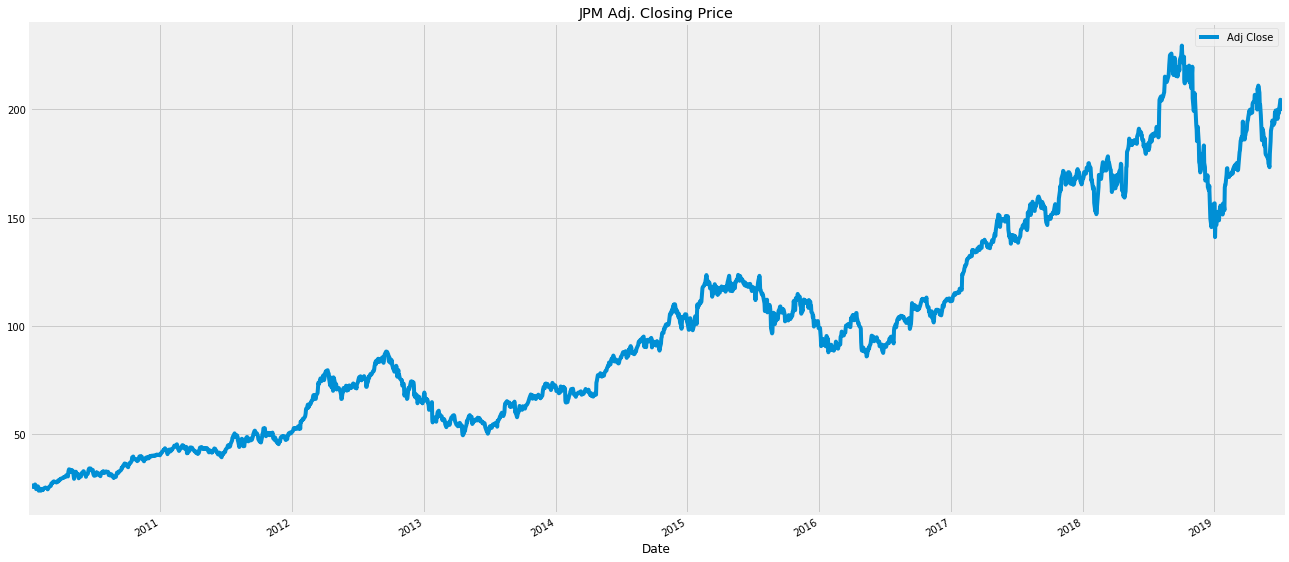

In [2]:
#Getting Data

todays_day = date.today() 
start = datetime.datetime(2010, 1, 1)
end = todays_day


jpm= pdr.get_data_yahoo("AAPL", start=start, end=end)['Adj Close']
df=pd.DataFrame(jpm)
df.plot(title='JPM Adj. Closing Price',figsize=(20,10))
df.tail()



# LSTM for Time Series Prediction

In [3]:
dataset = df

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [6]:
# convert an array of values into a dataset matrix
# Give X look_back time what will tomorrows prediction be?
def create_dataset(dataset, look_back=8):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [7]:
# reshape into X=t and Y=t+1
import numpy as np
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [8]:
sgd = SGD(lr=0.1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=sgd)




Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=20)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 5s - loss: 0.0020
Epoch 2/50
 - 5s - loss: 1.7163e-04
Epoch 3/50
 - 5s - loss: 1.3408e-04
Epoch 4/50
 - 4s - loss: 1.2163e-04
Epoch 5/50
 - 4s - loss: 1.2233e-04
Epoch 6/50
 - 5s - loss: 1.1751e-04
Epoch 7/50
 - 6s - loss: 1.1948e-04
Epoch 8/50
 - 5s - loss: 1.1360e-04
Epoch 9/50
 - 5s - loss: 1.1671e-04
Epoch 10/50
 - 5s - loss: 1.1855e-04
Epoch 11/50
 - 5s - loss: 1.1300e-04
Epoch 12/50
 - 5s - loss: 1.1228e-04
Epoch 13/50
 - 5s - loss: 1.1247e-04
Epoch 14/50
 - 5s - loss: 1.0919e-04
Epoch 15/50
 - 5s - loss: 1.0894e-04
Epoch 16/50
 - 5s - loss: 1.1079e-04
Epoch 17/50
 - 5s - loss: 1.0896e-04
Epoch 18/50
 - 5s - loss: 1.0883e-04
Epoch 19/50
 - 5s - loss: 1.0535e-04
Epoch 20/50
 - 5s - loss: 1.0615e-04
Epoch 21/50
 - 5s - loss: 1.0615e-04
Epoch 22/50
 - 5s - loss: 1.0509e-04
Epoch 23/50
 - 5s - loss: 1.0191e-04
Epoch 24/50
 - 5s - loss: 1.0213e-04
Epoch 25/50
 - 5s - loss: 1.0153e-04
Epoch 26/50
 - 5s - loss: 9.9676e-05
Epo

In [10]:
model.save("aapl_ac.h5")

In [11]:
from keras.models import load_model
model = load_model("aapl_ac.h5")

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [13]:
fake_10 = [[100,101,110,105,100,101,110,105,120,130]]
processed_fake_10 = scaler.transform(fake_10)
processed_fake_10.reshape(1,10,1)
output = model.predict(processed_fake_10.reshape(1,10,1))
scaler.inverse_transform(output)

array([[116.997696]], dtype=float32)

In [14]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [15]:
len(testPredict)

780

In [144]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
LSTM_MSE  = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (LSTM_MSE))



Train Score: 1.74 RMSE
Test Score: 18.94 RMSE


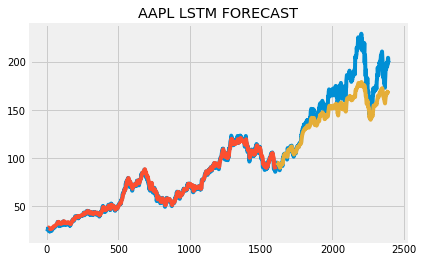

In [17]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("AAPL LSTM FORECAST")
plt.savefig("Images/AAPL_LSTM_img.png")
plt.show()

# Autoregressive integrated moving average (ARIMA)

In [18]:
dataset=df

In [19]:
#Getting the Data
todays_day = date.today() 
start = datetime.datetime(2010, 1, 1)
end = todays_day


jpm= pdr.get_data_yahoo("JPM", start=start, end=end)['Adj Close']
df=pd.DataFrame(jpm)
df.head()


,Adj Close
Date,
2010-01-04,33.765362
2010-01-05,34.419384
2010-01-06,34.608521
2010-01-07,35.294060
2010-01-08,35.207386


In [20]:
# The 'MS' string groups the data in buckets by start of the period
y=df
y = y['Adj Close'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

In [21]:
#Parameter Selection for the ARIMA Time Series Model

# p is the number of autoregressive terms,
# d is the number of nonseasonal differences needed for stationarity, and
# q is the number of lagged forecast errors in the prediction equation

# ARIMA(p,d,q) forecasting equation
# ARIMA(1,0,0) = first-order autoregressive model
# ARIMA(0,1,0) = random walk 
# ARIMA(1,1,0) = differenced first-order autoregressive model 
# ARIMA(0,1,1) without constant = simple exponential smoothing 
# ARIMA(0,1,1) with constant = simple exponential smoothing with growth 
# ARIMA(0,2,1) or (0,2,2) without constant = linear exponential smoothing 
# ARIMA(1,1,2) with constant = damped-trend linear exponential smoothing 




# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=True)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1277.40090280363
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:823.861944960088
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:717.4031991207173
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:775.0029729922068
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:735.6483445183184
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:722.5112944270545
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:716.5213508897559
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1119.6429180406171
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:663.8269287823039
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:628.77598190059
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:559.482783715459
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:507.73476972022775
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:552.9849443629203
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:466.65306636933894
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:511.6911647968883
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:509.07904901877464
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:487.81329122064045
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:468.6530264737598
ARIMA(0, 1

In [23]:
#Fitting an ARIMA Time Series Model
mod= sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4930      0.196     -2.521      0.012      -0.876      -0.110
ma.L1          0.7761      0.148      5.241      0.000       0.486       1.066
ar.S.L12    1.203e-05      0.155   7.76e-05      1.000      -0.304       0.304
ma.S.L12      -1.0001    421.172     -0.002      0.998    -826.482     824.481
sigma2         7.8278   3297.341      0.002      0.998   -6454.842    6470.497


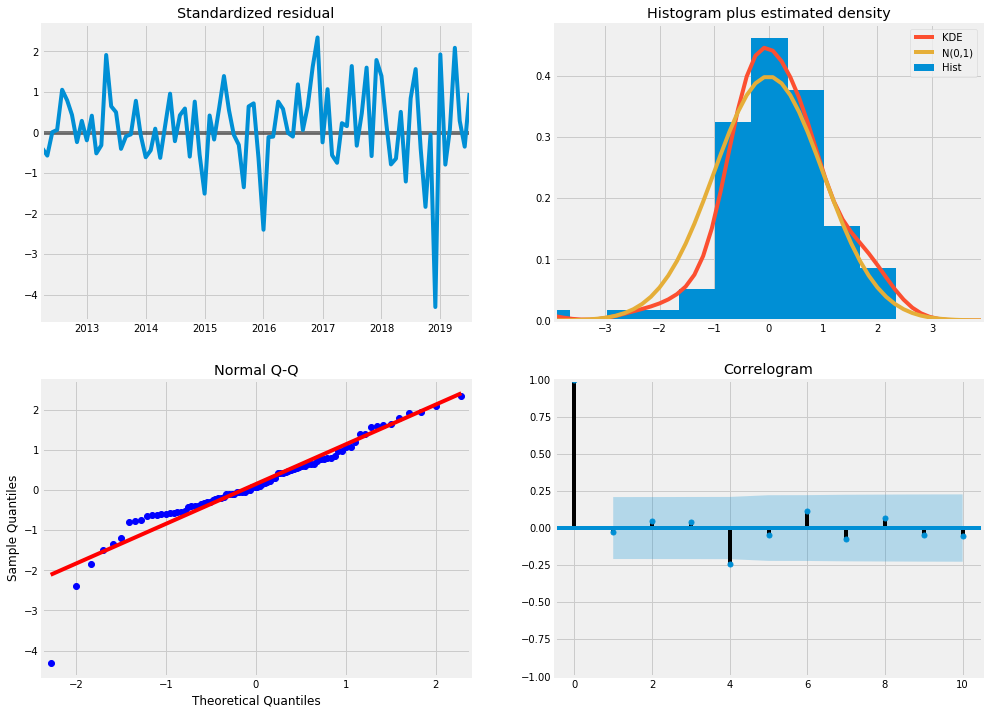

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [25]:
# Validating Forecasts
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()

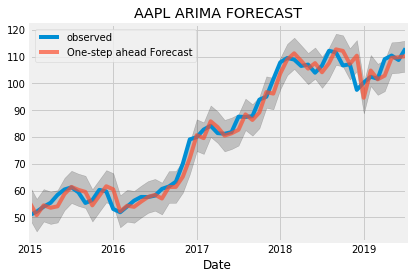

In [26]:
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
# ax.set_ylabel('Index')
plt.title("AAPL ARIMA FORECAST")
plt.legend()
plt.show()

In [152]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
ARIMA_MSE1 = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is{}'.format(round(ARIMA_MSE1, 2)))


The Mean Squared Error is12.44


In [28]:
# A better representation of our true predictive power can be obtained using dynamic 
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

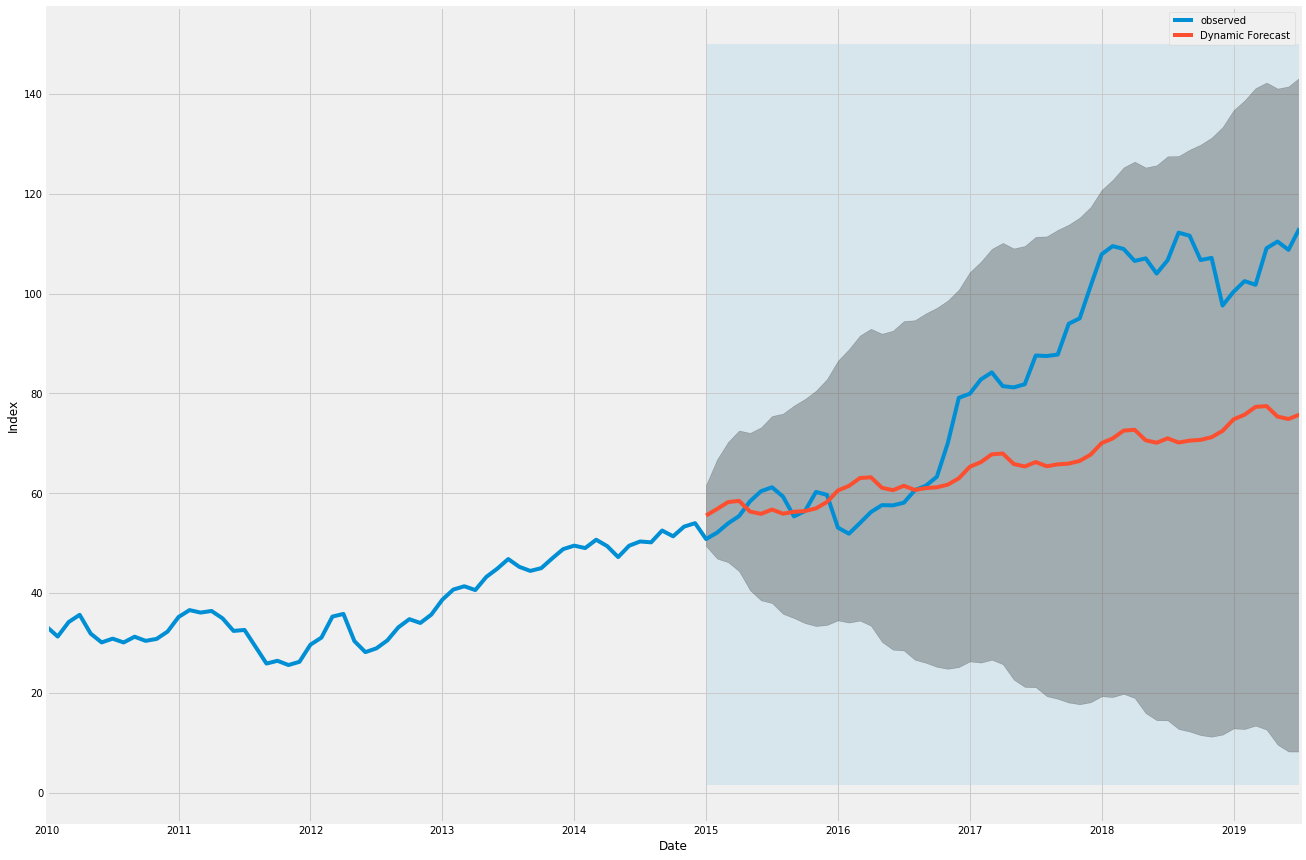

In [29]:
ax = y['2010':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()


In [30]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
ARIMA_MSE = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(ARIMA_MSE, 2)))

The Mean Squared Error of our forecasts is 526.11


In [31]:
#Producing and Visualizing Forecasts
# Get forecast # steps ahead in future
pred_uc = results.get_forecast(steps=40)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

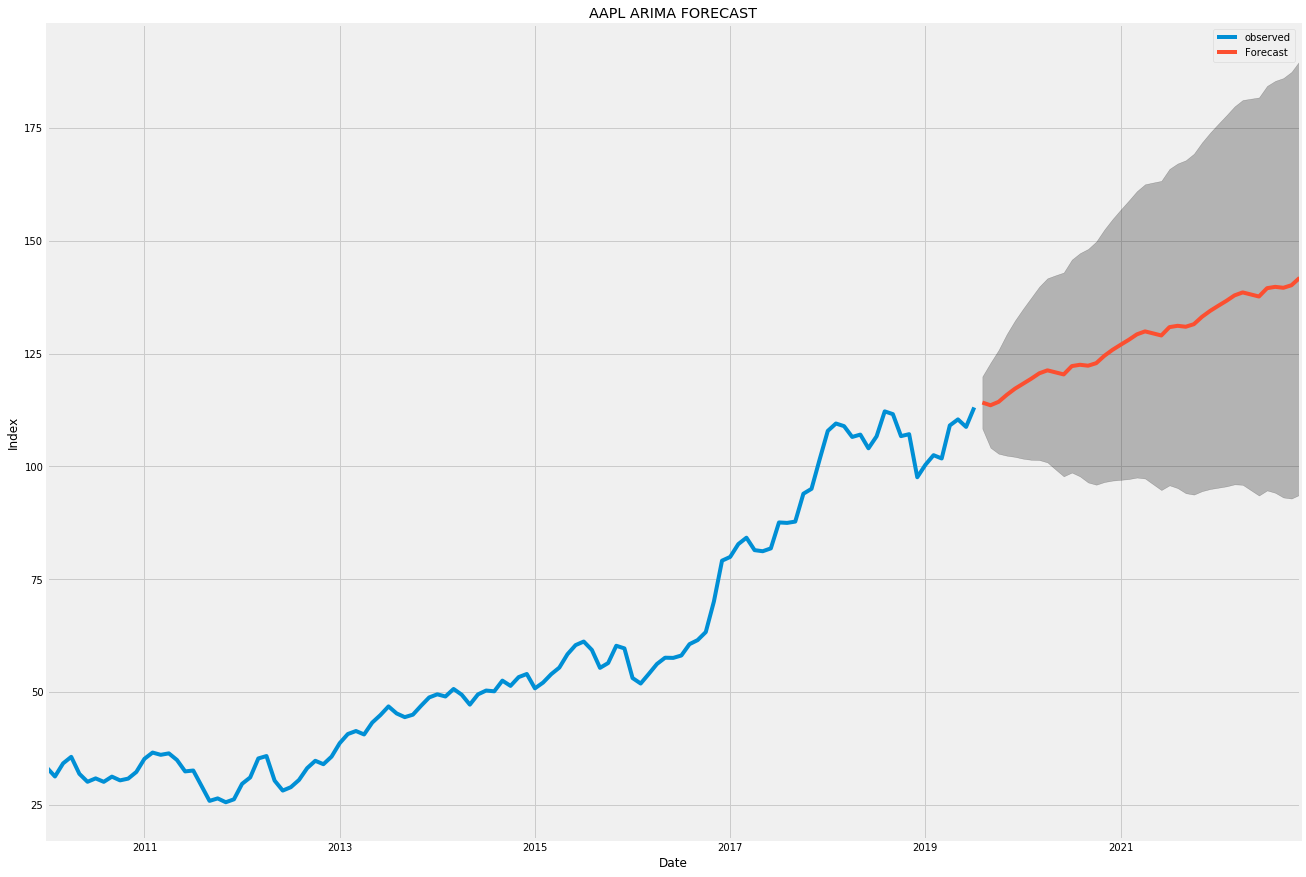

In [32]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.title("AAPL ARIMA FORECAST")
plt.savefig("Images/AAPL_ARIMA_img.png")
plt.show()




# Brownian Motion

In [33]:
#Getting Data
ts = TimeSeries(key='VW8RXL88BTZWTRN4', output_format='pandas')
data, meta_data = ts.get_intraday(symbol='JPM',interval='1min', outputsize='full')

In [34]:
# We can describe it
data['4. close']
data = data['4. close']
df=pd.DataFrame(data)
df.tail()

#Using Quandl
# start = "2010-01-01"
# end = "2018-06-30"
# df = quandl.get("WIKI/AAPL.4",start_date=start, end_date=end)
# df.plot(figsize=(20,10))
# df.head()

,4. close
date,
2019-07-09 15:56:00,113.450
2019-07-09 15:57:00,113.465
2019-07-09 15:58:00,113.480
2019-07-09 15:59:00,113.400
2019-07-09 16:00:00,113.360


In [35]:
Close = df['4. close']
time = np.linspace(1, len(Close), len(Close))


In [36]:
seed = 5       
N  = 2.**6     # increments

def Brownian(seed, N):
    
    np.random.seed(seed)                         
    dt = 1./N                                    # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)                             # brownian path
    return W, b


# brownian increments
b = Brownian(seed, N)[1]

# brownian motion
W = Brownian(seed, N)[0]
W = np.insert(W, 0, 0.) 

In [37]:
def daily_return(Close):
    returns = []
    for i in range(0, len(Close)-1):
        today = Close[i+1]
        yesterday = Close[i]
        daily_return = (today - yesterday)/yesterday
        returns.append(daily_return)
    return returns

returns = daily_return(Close)

mu = np.mean(returns)*252.           # drift coefficient
sig = np.std(returns)*np.sqrt(252.)  # diffusion coefficient

print(mu, sig)

-0.000119437125699605 0.008138396769030186


Text(0.5, 1.0, 'Geometric Brownian Motion - JPM')

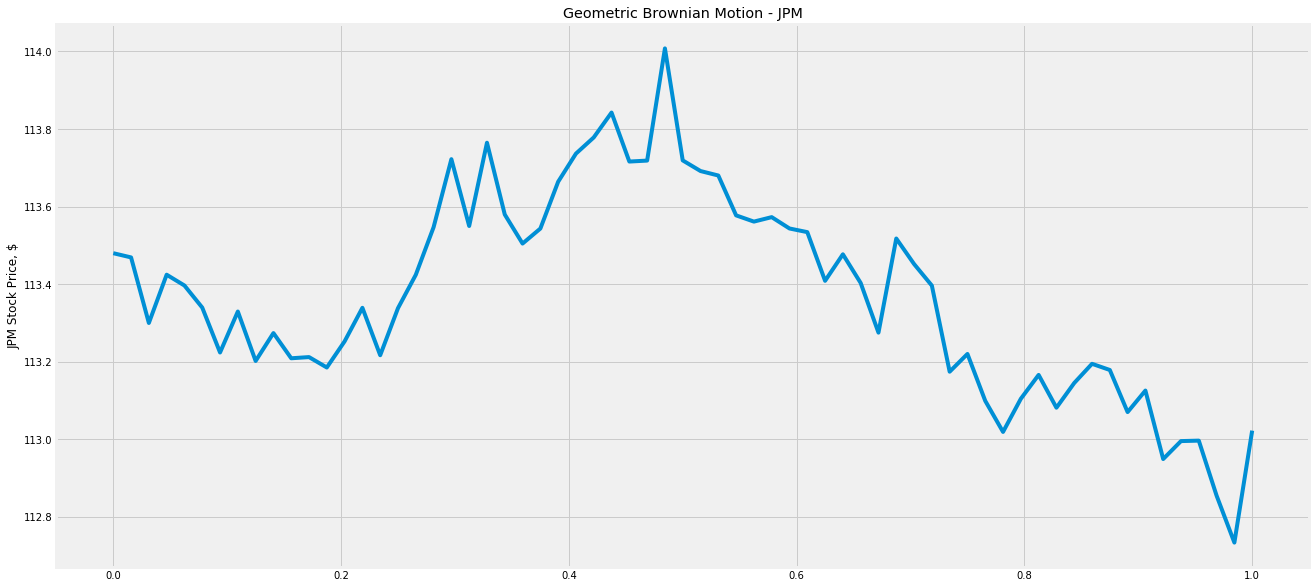

In [38]:
# GBM Exact Solution

# Parameters
#
# So:     initial stock price
# mu:     returns (drift coefficient)
# sigma:  volatility (diffusion coefficient)
# W:      brownian motion
# T:      time period
# N:      number of increments

def GBM(So, mu, sigma, W, T, N):    
    t = np.linspace(0.,1.,N+1)
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

seed = 22
So = Close[0]            # Initial Stock price 
W = Brownian(seed, N)[0]
T = 1.
N = 2.**6

soln = GBM(So, mu, sig, W, T, N)[0]    # Exact solution
t = GBM(So, mu, sig, W, T, N)[1]       # time increments for  plotting

plt.figure(figsize=(20,10))
plt.plot(t, soln)
plt.ylabel('JPM Stock Price, $')
plt.title('Geometric Brownian Motion - JPM')

In [39]:
Close = df['4. close']


In [40]:
def daily_return(Close):
    returns = []
    for i in range(0, len(Close)-1):
        today = Close[i+1]
        yesterday = Close[i]
        daily_return = (today - yesterday)/yesterday
        returns.append(daily_return)
    return returns

returns = daily_return(Close)

mu = np.mean(returns)*252.           # drift coefficient
sig = np.std(returns)*np.sqrt(252.)  # diffusion coefficient

print(mu, sig)

-0.000119437125699605 0.008138396769030186


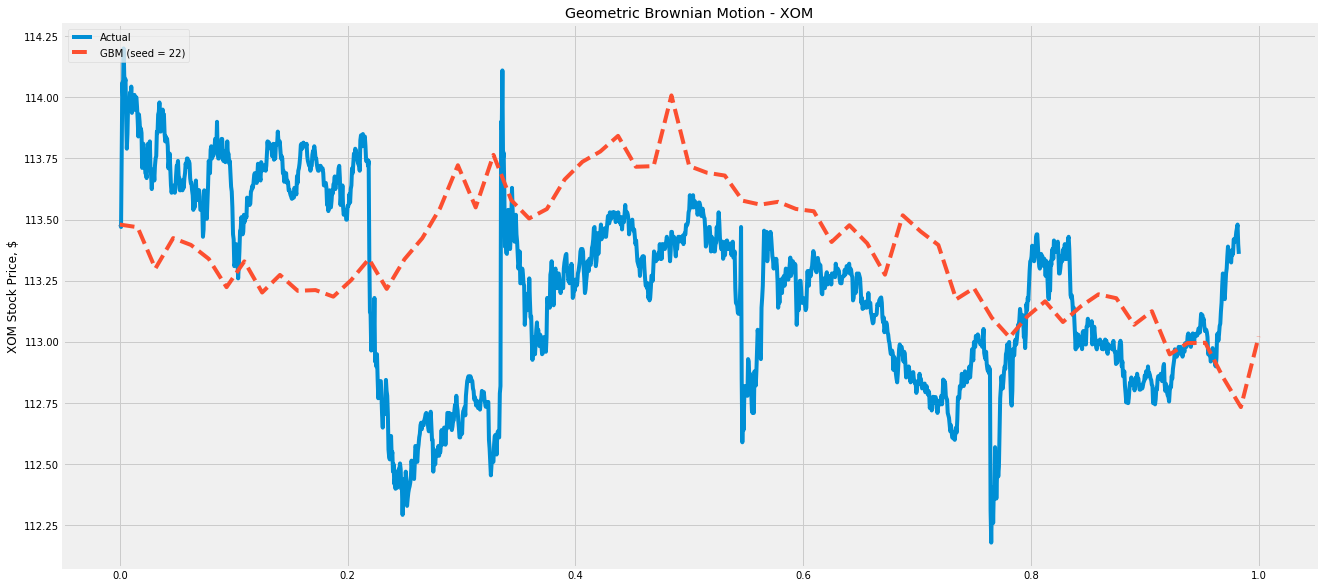

In [41]:
# adjusting the original time array 
time = np.linspace(1, len(Close), len(Close))
time = [i/1780. for i in time]

plt.figure(figsize=(20,10))
plt.plot(time, Close, label = 'Actual')
plt.plot(t, soln, label = 'GBM (seed = 22)', ls='--')

plt.ylabel('XOM Stock Price, $')
plt.title('Geometric Brownian Motion - XOM')

plt.legend(loc = 'upper left')

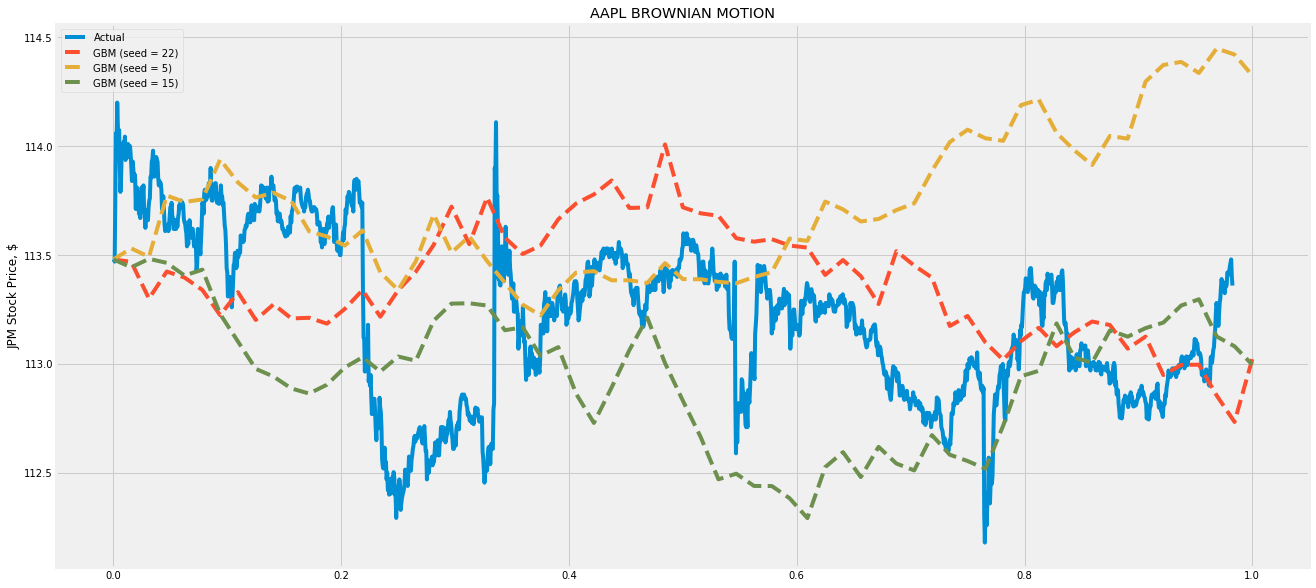

In [42]:
T = 1.
N = 2.**6
So = Close[0]

seed = 5
W = Brownian(seed, N)[0]
soln2 = GBM(So, mu, sig, W, T, N)[0]    

seed = 15
W = Brownian(seed, N)[0]
soln3 = GBM(So, mu, sig, W, T, N)[0]    

# adjusting the original time array 
time = np.linspace(1, len(Close), len(Close))
time = [i/1780. for i in time]

plt.figure(figsize=(20,10))
plt.plot(time, Close, label = 'Actual')
plt.plot(t, soln, label = 'GBM (seed = 22)', ls = '--')
plt.plot(t, soln2, label = 'GBM (seed = 5)', ls = '--')
plt.plot(t, soln3, label = 'GBM (seed = 15)', ls = '--')

plt.ylabel('JPM Stock Price, $')
plt.legend(loc = 'upper left')
plt.title('Geometric Brownian Motion - JPM')
plt.title("AAPL BROWNIAN MOTION")
plt.savefig("Images/AAPL_BM_img.png")



Euler-Maruyama Mode

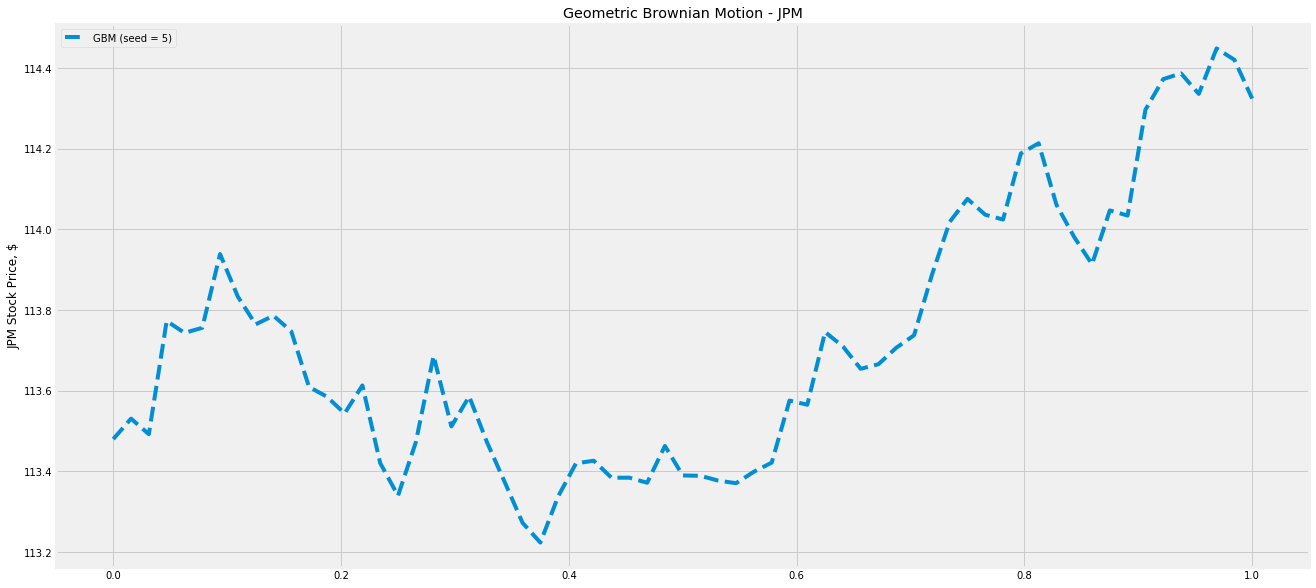

In [43]:
T = 1.
N = 2.**6
So = Close[0]

seed = 5
W = Brownian(seed, N)[0]
soln2 = GBM(So, mu, sig, W, T, N)[0]    

plt.figure(figsize=(20,10))
plt.plot(t, soln2, label = 'GBM (seed = 5)', ls = '--')

plt.ylabel('JPM Stock Price, $')
plt.title('Geometric Brownian Motion - JPM')

plt.legend(loc = 'upper left')

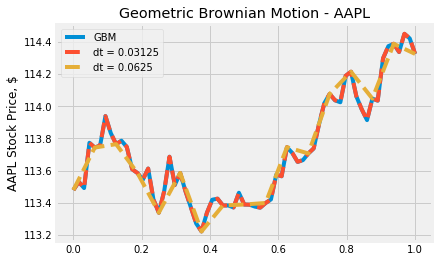

In [44]:
# Exact solution - GBM Model
seed = 5
So = Close[0]            # Initial Stock price 
W = Brownian(seed, N)[0]
T = 1.
N = 2.**6

soln = GBM(So, mu, sig, W, T, N)[0]    # Exact solution
t = GBM(So, mu, sig, W, T, N)[1]       # time increments for  plotting
plt.plot(t, soln, label ='GBM')


# Euler Maruyama Approximation
def EM(So, mu, sigma, b, T, N, M):
    dt = M * (1/N)  # EM step size
    L = N / M
    wi = [So]
    for i in range(0,int(L)):
        Winc = np.sum(b[(M*(i-1)+M):(M*i + M)])
        w_i_new = wi[i]+mu*wi[i]*dt+sigma*wi[i]*Winc
        wi.append(w_i_new)
    return wi, dt


# Changing the time step sizes
#
# dt = 0.03125
b = Brownian(5, N)[1]    # Brownian increments 
M = 1                    
L = N/M
EM_approx_1 = EM(So, mu, sig, b, T, N, M)[0]
time_EM_1 = np.linspace(0.,1.,L+1)

# dt = 0.0625
b = Brownian(5, N)[1]    # Brownian increments 
M = 4                    
L = N/M
EM_approx_2 = EM(So, mu, sig, b, T, N, M)[0]
time_EM_2 = np.linspace(0.,1.,L+1)


plt.plot(time_EM_1, EM_approx_1, label = 'dt = 0.03125', ls ='--')
plt.plot(time_EM_2, EM_approx_2, label = 'dt = 0.0625', ls ='--')


plt.ylabel('AAPL Stock Price, $')
plt.title('Geometric Brownian Motion - AAPL')

plt.legend(loc = 'upper left')

# Prophet

In [85]:
#Getting the Data
todays_day = date.today() 
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019,7,9)


aapl= pdr.get_data_yahoo("AAPL", start=start, end=end)['Adj Close']

aapl=pd.DataFrame(aapl)



In [86]:
#Adjustin the Data to the model
aapl['Date'] = aapl.index
aapl.tail()

,Adj Close,Date
Date,,
2019-07-02,202.729996,2019-07-02
2019-07-03,204.410004,2019-07-03
2019-07-05,204.229996,2019-07-05
2019-07-08,200.020004,2019-07-08
2019-07-09,201.240005,2019-07-09


In [87]:
# Prophet requires columns ds (Date) and y (value)
aapl = aapl.rename(columns={'Date': 'ds', 'Adj Close': 'y'})
aapl.tail()

,y,ds
Date,,
2019-07-02,202.729996,2019-07-02
2019-07-03,204.410004,2019-07-03
2019-07-05,204.229996,2019-07-05
2019-07-08,200.020004,2019-07-08
2019-07-09,201.240005,2019-07-09


In [88]:
# Put market cap in billions
aapl['y'] = aapl['y'] / 1e9
# Make the prophet model and fit on the data
aapl_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
aapl_prophet.fit(aapl)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
# Make a future dataframe for 2 years
aapl_forecast = aapl_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
aapl_forecast = aapl_prophet.predict(aapl_forecast)


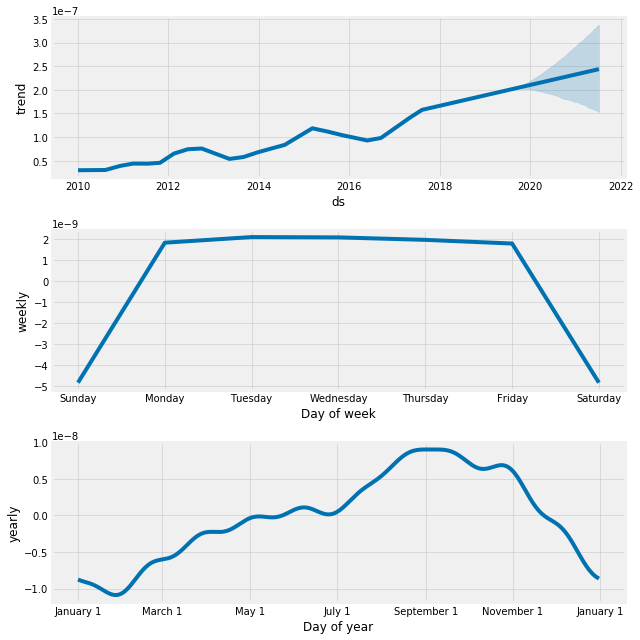

In [101]:
plot2 = model.plot_components(aapl_forecast)

In [128]:
# Cross Validation
# horizon: the forecast horizon
# initial: the size of the initial training period
# period: the spacing between cutoff dates

from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='3200 days', period='90 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-10-12 00:00:00 and 2019-01-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-10-15,2.082158e-07,2.029930e-07,2.144158e-07,2.148518e-07,2018-10-12
1,2018-10-16,2.083787e-07,2.022565e-07,2.142538e-07,2.195865e-07,2018-10-12
2,2018-10-17,2.085146e-07,2.030848e-07,2.143760e-07,2.186376e-07,2018-10-12
3,2018-10-18,2.085579e-07,2.030220e-07,2.144966e-07,2.135273e-07,2018-10-12
4,2018-10-19,2.085922e-07,2.027900e-07,2.144975e-07,2.167793e-07,2018-10-12


In [129]:
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'] == cutoff]

In [130]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,18 days,5.373780e-17,7.330607e-09,6.375156e-09,0.029336,0.416667
1,19 days,5.286864e-17,7.271083e-09,6.305250e-09,0.028996,0.500000
2,20 days,4.930439e-17,7.021709e-09,6.129755e-09,0.028195,0.500000
3,21 days,4.324278e-17,6.575925e-09,5.740596e-09,0.026553,0.583333
4,24 days,5.236280e-17,7.236215e-09,6.291621e-09,0.029457,0.500000


In [141]:
df_p = performance_metrics(df_cv)['mse'].mean()
Prophet_MSE = df_p 
Prophet_MSE

1.970375646010787e-15

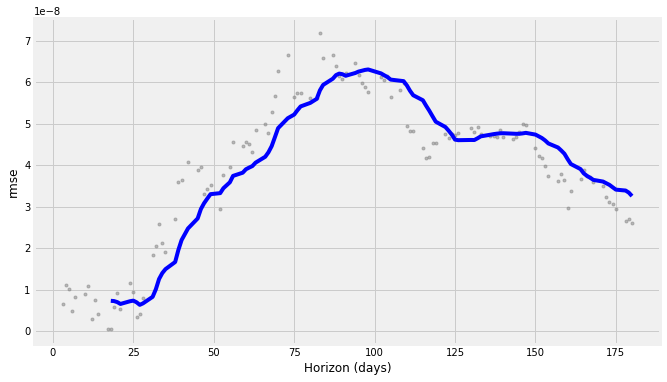

In [131]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

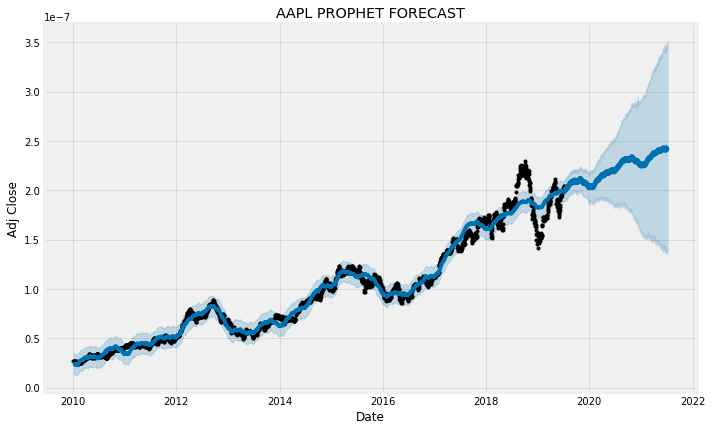

In [51]:
aapl_prophet.plot(aapl_forecast, xlabel = 'Date', ylabel = 'Adj Close');
plt.title("AAPL PROPHET FORECAST")
plt.savefig("Images/AAPL_Prophet_img.png")

Effect of Changepoint Prior Scale

In [52]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(aapl)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    aapl[changepoint] = future['yhat']

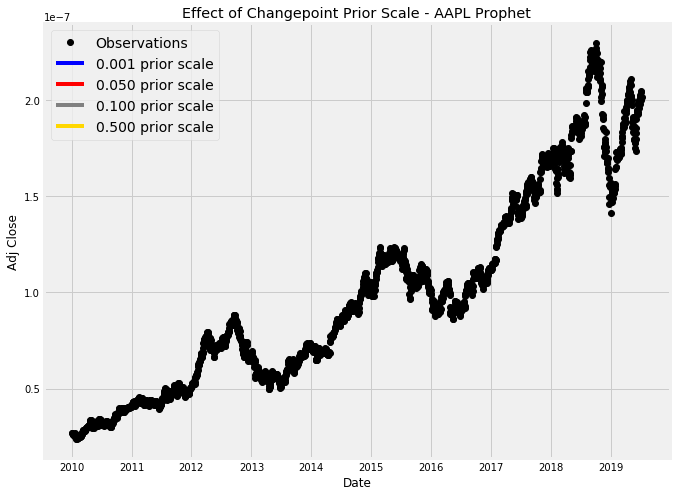

In [53]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(aapl['ds'], aapl['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(aapl['ds'], aapl[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Adj Close'); plt.title('Effect of Changepoint Prior Scale - AAPL Prophet');

In [54]:
aapl_prophet.changepoints[:10]

77    2010-04-26
153   2010-08-12
230   2010-12-01
306   2011-03-22
383   2011-07-12
459   2011-10-27
536   2012-02-17
612   2012-06-07
689   2012-09-26
766   2013-01-18
Name: ds, dtype: datetime64[ns]

# Summary

# 2) Investment Portfolios

In [55]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity


def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [56]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [57]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T
    
    return portfolios

In [58]:
stocks = {
    "Apple": "AAPL",
    "Amazon": "AMZN",
    "Exxon Mobil": "XOM",
    "Microsoft": "MSFT",
    "JP Morgan": "JPM"
#    # "Diversified Fixed Income Portfolio":"DFXIX"
#     "STANDARD POORS":"SPX"
}
stock_df = pd.DataFrame()
stock_symbols = list(stocks.values())# stocks = pd.DataFrame(list(stocks.items()), columns=["name", "symbol"])
ts = TimeSeries(key="VW8RXL88BTZWTRN4",output_format='pandas')
symbols = []
for symbol in stock_symbols:
    symbols.append(symbol)
    print(symbol)
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    close = data['4. close']
    stock_df = pd.concat([stock_df, close], axis=1)

AAPL
AMZN
XOM
MSFT
JPM


In [59]:
stock_df.columns = symbols
stock_df.tail()

,AAPL,AMZN,XOM,MSFT,JPM
date,,,,,
2019-07-02,202.73,1934.31,75.72,136.58,113.80
2019-07-03,204.41,1939.00,76.44,137.46,112.82
2019-07-05,204.23,1942.91,76.13,137.06,113.49
2019-07-08,200.02,1952.32,76.48,136.96,112.87
2019-07-09,201.24,1988.30,76.43,136.46,113.35


In [60]:
range_stock_df = stock_df["2010-01-01":"2019-07-05"]
returns = range_stock_df.to_returns().dropna()
portfolios = get_all_portfolios(returns)


     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  8e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  5e-17  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  1e-16  1e-04
 3: -9.9999e-01 -1.0000e+00  6e-06  1e-16  7e-06
 4: -9.9999e-01 -1.0000e+00  2e-06  2e-16  5e-17
 5: -9.9999e-01 -9.9999e-01  1e-07  3e-17  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  5e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  9e-17  1e-04
 3: -9.9999e-01 -1.0000e+00  6e-06  2e-16  7e-06
 4: -9.9999e-01 -1.0000e+00  2e-06  3e-17  1e-16
 5: -9.9999e-01 -9.9999e-01  2e-07  6e-17  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  3e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  7e-17  1e-04
 3: -9.9999e-01 -1.0000e+00  7e-06  7e-17  8e-06
 4: -9.9999e-01 -9.9999e

 1: -9.9858e-01 -1.0096e+00  1e-02  6e-17  1e-02
 2: -9.9864e-01 -9.9959e-01  9e-04  8e-17  1e-03
 3: -9.9885e-01 -9.9911e-01  3e-04  2e-16  7e-17
 4: -9.9887e-01 -9.9889e-01  2e-05  1e-16  8e-17
 5: -9.9887e-01 -9.9887e-01  8e-07  1e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9840e-01 -1.9996e+00  1e+00  2e-16  1e+00
 1: -9.9840e-01 -1.0095e+00  1e-02  1e-16  1e-02
 2: -9.9848e-01 -9.9951e-01  1e-03  1e-16  1e-03
 3: -9.9871e-01 -9.9899e-01  3e-04  2e-16  2e-17
 4: -9.9873e-01 -9.9876e-01  2e-05  1e-16  7e-17
 5: -9.9873e-01 -9.9873e-01  8e-07  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9821e-01 -1.9995e+00  1e+00  0e+00  1e+00
 1: -9.9821e-01 -1.0095e+00  1e-02  1e-16  1e-02
 2: -9.9830e-01 -9.9943e-01  1e-03  1e-16  1e-03
 3: -9.9856e-01 -9.9885e-01  3e-04  2e-16  8e-17
 4: -9.9858e-01 -9.9860e-01  3e-05  1e-16  7e-17
 5: -9.9858e-01 -9.9858e-01  8e-07  1e-16  5e-17
Optimal solution found.

 2: -8.3949e-01 -8.5044e-01  1e-02  1e-16  1e-16
 3: -8.4042e-01 -8.4113e-01  7e-04  1e-16  6e-17
 4: -8.4044e-01 -8.4046e-01  1e-05  1e-16  8e-17
 5: -8.4044e-01 -8.4044e-01  1e-07  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.0080e-01 -1.8874e+00  1e+00  0e+00  1e+00
 1: -8.0660e-01 -8.8387e-01  8e-02  1e-16  9e-02
 2: -8.2003e-01 -8.3076e-01  1e-02  1e-16  6e-17
 3: -8.2095e-01 -8.2162e-01  7e-04  1e-16  8e-17
 4: -8.2097e-01 -8.2099e-01  1e-05  2e-16  6e-17
 5: -8.2097e-01 -8.2097e-01  1e-07  1e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.7806e-01 -1.8703e+00  1e+00  2e-16  1e+00
 1: -7.8461e-01 -8.6454e-01  8e-02  1e-16  9e-02
 2: -7.9821e-01 -8.0865e-01  1e-02  1e-16  8e-17
 3: -7.9911e-01 -7.9973e-01  6e-04  1e-16  1e-16
 4: -7.9913e-01 -7.9914e-01  1e-05  3e-17  6e-17
 5: -7.9913e-01 -7.9913e-01  1e-07  4e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres


In [61]:
portfolios

,MVP,IVP,HRP
AAPL,0.065264,0.086136,0.107648
AMZN,0.063579,0.125361,0.086338
XOM,0.584362,0.358843,0.448461
MSFT,0.216780,0.235367,0.162100
JPM,0.070015,0.194294,0.195453
